## 06. 군집화 실습 - 고객 세그먼테이션

**고객 세그먼테이션의 정의와 기법**

고객 세그먼테이션(Customer Segmentation)은 다양한 기준으로 고객을 분류하는 기법을 지칭한다. 고객 세그먼테이션은 CRM이나 마케팅의 중요 기반 요소이다.

고객을 분류하는 요소로 지역/결혼 여부/성별/소득과 같이 개인의 신상 데이터가 사용될 수도 있지만, 고객 분류가 사용되는 대부분의 비즈니스가 상품 판매에 중점을 두고 있기 때문에 **어떤 상품을 얼마나 많은 비용을 써서 얼마나 자주 사용하는지에 대한 정보**로 분류하는 것이 보통이다. 기업 입장에서는 얼마나 많은 매출을 발생하느냐가 고객 기준을 정하는 중요한 요소이다.

고객 세그먼테이션의 주요 목표는 타깃 마케팅이다. 타깃 마케팅이란 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것이다. 평소에 많은 돈을 지불해 서비스를 이용하고 있다면 VIP 전용 상품의 가입을 권유하는 전화나 이메일을 많이 받아봤을 것이다. 새로운 상품이나 서비스를 적극적으로 이용해왔다면 프로모션 상품이 출시될 때마다 권유를 받았을 것이다. 이처럼 기업의 마케팅은 고객의 상품 구매 이력에서 출발한다.

고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용한다. RFM 기법은 Recency(R), Frequency(F), Monetary Value(M)의 각 앞 글자를 합한 것으로 각 단어의 의미는 다음과 같다.

* RECENCY(R) : 가장 최근 상품 구입일에서 오늘까지의 기간
* FREQUENCY(F) : 상품 구매 횟수
* MONETARY VALUE(M) : 총 구매 금액

이번 절에서는 온라인 판매 데이터를 기반으로 고객 세그먼테이션을 군집화 기반으로 수행해 보겠다.

**데이터 세트 로딩과 데이터 클렌징**

예제에 사용할 데이터 세트 : http://archive.ics.uci.edu/ml/datasets/online+retail

엑셀 파일을 판다스의 read_excel() 함수를 이용해 DataFrame으로 로드한다.

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df=pd.read_excel("C:/Users/User/Desktop/2024-1/ESAA/사용 데이터/Online Retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


이 데이터 세트는 제품 주문 데이터 세트이다. Invoice(주문번호)+StockCode(제품코드)를 기반으로 주문량, 주문 일자, 제품 단가, 주문 고객 번호, 주문 고객 국가 등의 칼럼으로 구성돼있다.

데이터 세트의 각 칼럼은 다음과 같다.

* InvoiceNo : 주문번호. 'C'로 시작하는 것은 취소 주문
* StockCode : 제품 코드(Item Code)
* Description : 제품 설명
* Quantity : 주문 제품 건수
* InvoiceDate : 주문 일자
* UnitPrice : 제품 단가
* CustomerID : 고객 번호
* Country : 국가명(주문 고객의 국적)

데이터 세트의 전체 건수, 칼럼 타입, Null 개수를 확인한다.

In [2]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


전체 데이터는 541,909개이다. 하지만 CustomerID의 Null 값이 너무 많고 그 외에 다른 칼럼의 경우도 오류 데이터가 존재하기 때문에 사전 정제 작업이 필요하다.

* Null 데이터 제거 : 특히 CustomerID가 Null인 데이터가 많다. 고객 세그먼테이션을 수행하므로 고객 식별 번호가 없는 데이터는 필요가 없기 때문에 삭제한다.
* 오류 데이터 삭제 : 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우이다. 사실 Quantity가 0보다 작은 경우는 오류 데이터라기보다는 반환을 뜻하는 값이다. 이 경우 InvoiceNo의 앞자리는 'C'로 돼있다. 분석의 효율성을 위해서 이 데이터는 모두 삭제한다.

불린 인덱싱을 적용해 Quantity>0, UnitPrice>0이고 CustomerID가 Not Null인 값만 다시 필터링한다.

In [3]:
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]
retail_df=retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

전체 데이터가 541,909에서 397,884로 줄었다. 이제 Null 값은 칼럼에 존재하지 않는다. 한 가지 사항만 더 정리하고 간략하게 데이터 사전 정제를 마친다. Country 칼럼은 주문 고객 국가이다. 주요 주문 고객은 영국인데, 이외에도 EU의 여러 나라와 영연방 국가들이 포함돼있다.

In [4]:
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외한다.

In [5]:
retail_df=retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


최종 데이터는 354,321건으로 줄었다.

**RFM 기반 데이터 가공**

이제 사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행한다. 이를 위해 필요한 데이터를 가공한다. 먼저 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터를 만든다. 그리고 CustomerNo도 더 편리한 식별성을 위해 float형을 int형으로 변경한다.

In [6]:
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)

해당 온라인 판매 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많다. 이는 개인 고객의 주문과 소매점의 주문이 함께 포함돼있기 때문이다. Top-5 주문 건수와 주문 금액을 가진 고객 데이터를 추출한다.

In [7]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


위의 결과에서 볼 수 있듯이 몇몇 특정 고객이 많은 주문 건수와 주문 금액을 가지고 있다. 주어진 온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문번호(InvoiceNo)+상품코드(StockCode) 레벨의 식별자로 돼있다. InvoiceNo+StockCode로 Group by를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨을 알 수 있다.

In [8]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

그런데 지금 수행하려는 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 세그먼테이션을 수행하는 것이다. 이에 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경한다. 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by해야 한다.

주문번호 기준의 retail_df DataFrame에 groupby('CustomerID')를 적용해 CustomerID 기준으로 DataFrame을 새롭게 생성한다. DataFrame의 groupby()만 사용해서는 여러 개의 칼럼에 서로 다른 aggregation 연산, 예를 들어 count()나 max()를 한 번에 수행하기 어렵다. 이를 해결하기 위해 DataFrame에 groupby를 호출해 반환된 DataFrameGroupby 객체에 agg()를 이용한다. agg()에 인자로 대상 칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation 연산을 쉽게 수행할 수 있다. Frequency는 고객별 주문 건수이므로 'CustomerID'로 groupby()해서 'InvoiceNo'의 count() aggregation으로 구한다. Monetary value는 고객별 주문 금액이므로 'CustomerID'로 groupby()해서 'sale_amount'의 sum() aggregation으로 구한다. Recency의 경우는 두 번의 가공 작업을 수행한다. 'CustomerID'로 groupby()해서 'InvoiceDate' 칼럼의 max()로 고객별 가장 최근 주문 일자를 먼저 구한 뒤 추후 가공 작업을 별도로 수행한다.

In [9]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency : InvoiceDate 칼럼의 max()에서 가공
# Frequency : InvoiceNo 칼럼의 count()
# Monetary : sale_amount 칼럼의 sum()
aggregations={
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}
cust_df=retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df=cust_df.rename(columns={'InvoiceDate' : 'Recency',
                                'InvoiceNo' : 'Frequency',
                                'sale_amount' : 'Monetary'
                               })
cust_df=cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


Recency 칼럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 아직 데이터 가공이 추가로 필요하다. Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜이다. 여기서 주의할 점은 오늘 날짜를 현재 날짜로 해서는 안된다는 것이다. 온라인 판매 데이터가 2010년 12월 1일에서 2011년 12월 9일까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 하겠다. 2011년 12월 10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성한다.

In [10]:
import datetime as dt
cust_df['Recency']=dt.datetime(2011, 12, 10)-cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


이제 고객별로 RFM 분석에 필요한 Recency, Frequency, Monetary 칼럼을 모두 생성했다. 다음으로는 생성된 고객 RFM 데이터 세트의 특성을 개괄적으로 알아보고 RFM 기반에서 고객 세그먼테이션을 수행한다.

**RFM 기반 고객 세그먼테이션**

온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함하고 있다. 이들은 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생하게 된다. 먼저 온라인 판매 데이터 세트의 칼럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는지 알아보겠다. 다음 예제 코드는 'Recency', 'Frequency', 'Monetary' 칼럼 값 분포 히스토그램을 나타낸다. 맷플롯립의 hist()를 이용해 각 칼럼의 값 분포도를 알아본다.

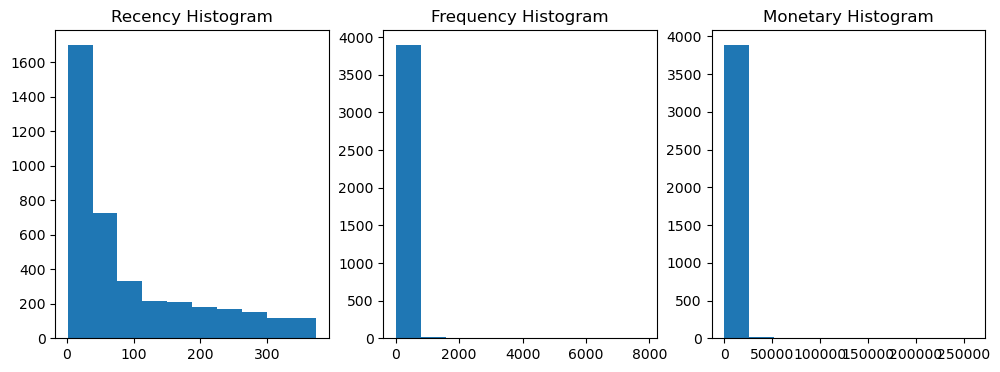

In [11]:
fig, (ax1, ax2, ax3)=plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

Recency, Frequency, Monetary 모두 왜곡된 데이터 값 분포도를 가지고 있으며, 특히 Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심하다. 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼있는지 확인한다.

In [12]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


Recency는 평균이 92.7으로, 50%(중위값 2/4 분위)인 51보다 높다. 그리고 max 값은 374으로 75%(3/4 분위)인 143보다 훨씬 커서 왜곡 정도가 높음을 알 수 있다. Frequency와 Monetary의 경우 왜곡 정도가 더 심하다. Frequency의 평균이 90.3인데, 75%인 99.25에 가깝다. 이는 max 값 7847을 포함한 상위 몇 개의 큰 값으로 인한 것이다. Monetary 역시 마찬가지로 평균은 1864.3으로 75%인 1576.5보다 매우 크다. 이는 max 값 259657.3을 포함한 상위 몇 개의 큰 값으로 인해 발생한 현상이다.

왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행된다. 먼저 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행한다.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나온다. 하지만 각 군집별 실루엣 계수 값은 어떨까? 2절 군집평가 예제에서 사용한 visualized_silhouette() 함수와 군집 개수별로 군집화 구성을 시각화하는 visualize_kmeans_plot_multi() 함수(해당 함수는 부록에서 제공되는 소스 코드에 있다) 개별 군집의 실루엣 계수 값과 데이터 구성을 함께 알아본다.

In [14]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [15]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_k

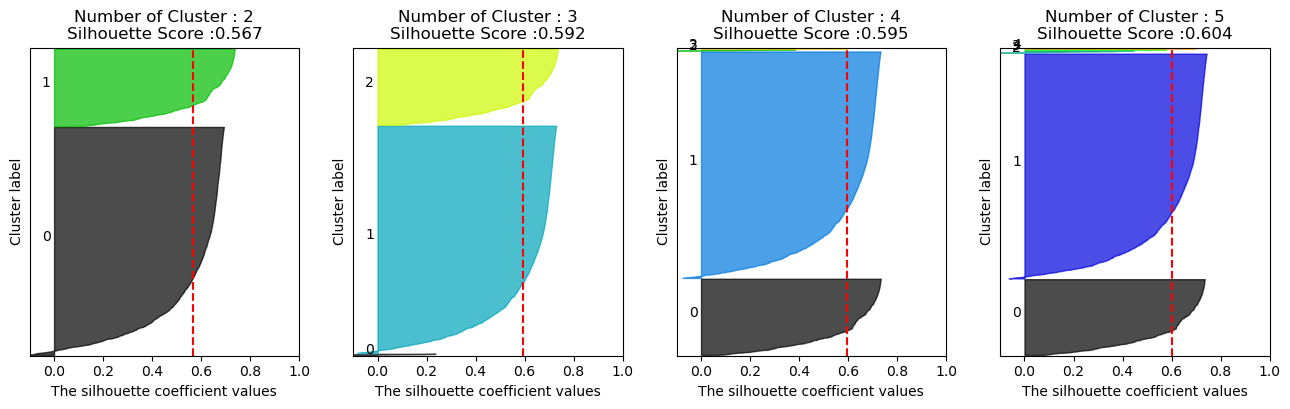

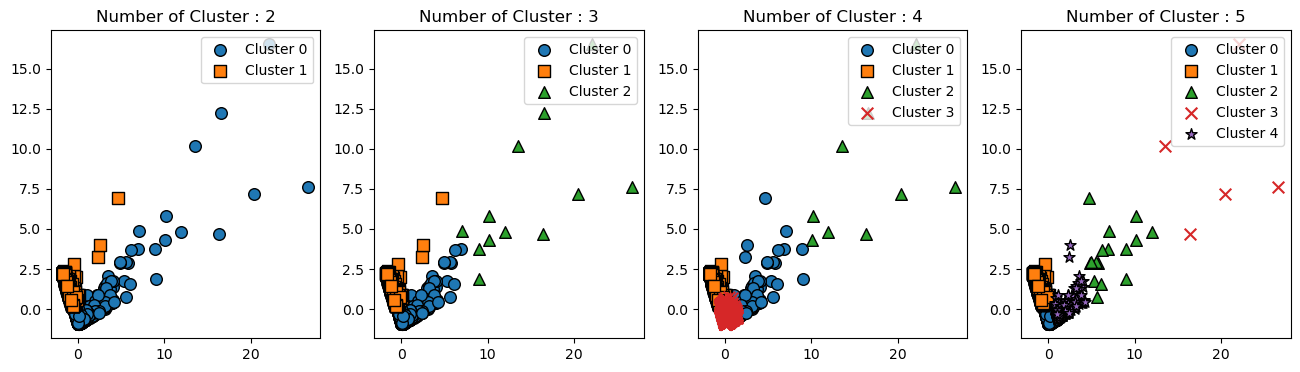

In [16]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

군집이 2개일 경우 0번 군집과 1번 군집이 너무 개괄적으로 군집화된다. 군집 수를 증가시키면 개선이 가능할 것으로 예상됐는데, 실제 결과는 다르다. 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어진다. 이 군집에 속한 데이터는 개수가 작을뿐더러 실루엣 계수 역시 상대적으로 매우 작다. 또한 군집 내부에서도 데이터가 광범위하게 퍼져 있다. 군집이 3개일 때는 0번 군집의 데이터 건수가 매우 작고, 4개일 때는 2번, 3번 군집이, 5개일 때는 2, 3, 4번 군집에 속한 데이터 세트의 개수가 너무 적고 광범위하게 퍼져 있다. 이 소수의 데이터 세트는 바로 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터이다. 이 데이터 세트의 경우 데이터 값이 거리 기반으로 광범위하게 퍼져 있어 군집 수를 계속 늘려봐야 이 군집만 지속적으로 분리하게 되기에 의미 없는 군집화 결과로 이어지게 된다.

물론 이런 특이한 데이터 세트를 분리하고 도출하는 것이 군집화의 목표이기도 하다. 하지만 이 정도로 크게 왜곡된 데이터 세트의 도출은 굳이 군집화를 이용하지 않고도 간단한 데이터 분석만으로도 충분히 가능하다. 더구나 업무 로직을 알고 있는 분석가라면 이미 이 정도의 세그먼테이션 결과는 미리 알고 있었을 것이다. 이처럼 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 된다.

비지도학습 알고리즘의 하나인 군집화의 기능적 의미는 숨어 있는 새로운 집단을 발견하는 것이다. 새로운 군집 내의 데이터 값을 분석하고 이해함으로써 이 집단에 새로운 의미를 부여할 수 있다. 이를 통해 전체 데이터를 다른 각도로 바라볼 수 있게 만들어 준다.

데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(log)를 적용하는 로그 변환이다. 온라인 판매 데이터 세트의 왜곡 정도를 낮추기 위해 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용하고 결과를 비교해 보자.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log']=np.log1p(cust_df['Recency'])
cust_df['Frequency_log']=np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']=np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features=cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled=StandardScaler().fit_transform(X_features)
kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.303


실루엣 스코어는 로그 변환 전보다 떨어진다. 하지만 실루엣 스코어의 절대치가 중요한 것이 아님을 앞의 예제에서 잘 알 수 있다. 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요하다. 로그 변환한 데이터 세트를 기반으로 실루엣 계수와 군집화 구성을 시각화한다.

실루엣 계수 : 각각의 데이터가 해당 데이터와 같은 군집 내의 데이터와는 얼마나 가깝게 군집화가 되었고, 다른 군집에 있는 데이터와는 얼마나 멀리 분포되어 있는지를 나타내는 지표

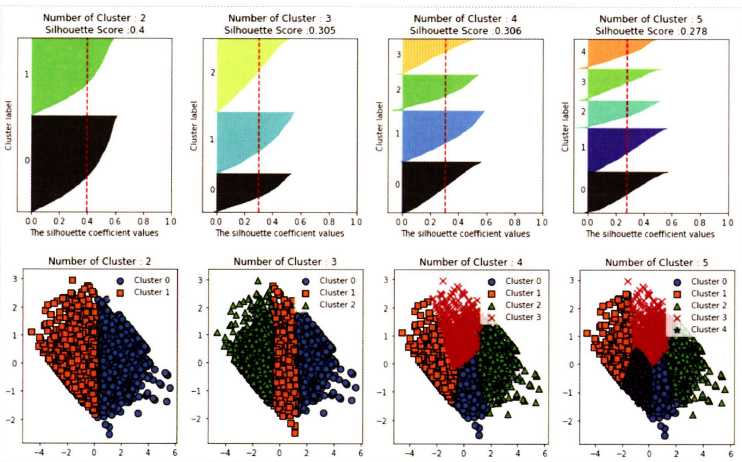

실루엣 스코어는 로그 변환 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성됐음을 알 수 있다. 이처럼 왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후 군집화를 수행하면 더 나은 결과를 도출할 수 있다.

## 07. 정리

이번 장에서는 다양한 머신러닝 기반의 군집화 기법을 소개했다. 각 군집화 기법은 장/단점을 가지고 있으며, 군집화하려는 데이터의 특성에 맞게 선택해야 한다.

K-평균의 경우 거리 기반으로 군집 중심점을 이동시키면서 군집화를 수행한다. 매우 쉽고 직관적인 알고리즘으로 많은 군집화 애플리케이션에 이용되지만, 복잡한 구조를 가지는 데이터 세트에 적용하기에는 한계가 있으며, 군집의 개수를 최적화하기 어렵다. K-평균은 군집이 잘 되었는지의 평가를 위해 실루엣 계수를 이용한다.

평균 이동(Mean Shift)은 K-평균과 유사하지만 거리 중심이 아니라 데이터의 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화를 수행한다. 일반 업무 기반의 정형 데이터 세트보다는 컴퓨터 비전 영역에서 이미지나 영상 데이터 중 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘이다.

GMM(Gaussian Mixture Model) 군집화는 군집화를 적용하고자 하는 데이터를 여러 개의 가우시안 분포(Gaussian Distribution) 모델을 섞어 생성된 모델로 가정해 수행하는 방식이다. 전체 데이터 세트에서 서로 다른 정규 분포 형태를 추출해 각기 다른 정규 분포를 가진 데이터 세트 각각을 군집화하는 것이다. GMM의 경우는 K-평균보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있다는 장점이 있지만 군집화를 위한 수행 시간이 오래 걸린다는 단점이 있다.

DBSCAN(Density Based Spatial Clustering of Applications with Noise)은 밀도 기반 군집화의 대표적인 알고리즘이다. DBSCAN은 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 핵심 포인트, 이웃 포인트, 경계 포인트, 잡음 포인트로 구분하고 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성하는 방식이다. DBSCAN은 간단하고 직관적인 알고리즘으로 돼있음에도 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능하다.